# Differential expression analysis
Data are EP1NS cells (ependymoma ZFTA-fusion cell line) treated with shL1CAM, shSHTN1, or shControl.
[DESeq2 docs](https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html).

## Required input files:
*shL1CAM-shSHTN1.expected_counts.tsv*.  
Generated by running RSEM on all samples using the following parameters:  
`rsem-calculate-expression --star --star-gzipped-read-file --paired-end --append-names $R1 $R2 $REF $SAMPLE`  
where the reference is ensembl 113 (GRCH38.p14)

*sample_metadata.tsv*.  
Sample metadata indicating shRNA treatments. Formatted as tsv of sample, treatment.

*Homo_sapiens.GRCh38.113.gtf*.  
Gene annotation file used for STAR, RSEM. Download from https://ftp.ensembl.org/pub/release-113/gtf/homo_sapiens/Homo_sapiens.GRCh38.113.gtf.gz.

In [1]:
# Load dependencies

Sys.setenv(LANGUAGE = "en") # set language to "ja" if you prefer
suppressWarnings(library(DESeq2))
suppressWarnings(library(plyranges))
suppressWarnings(library(dplyr))
suppressWarnings(library(tibble))
suppressWarnings(library(readr))
suppressWarnings(library(ggplot2))
suppressWarnings(library(ggrepel))
suppressWarnings(library(extrafont))
suppressWarnings(library(svglite))
suppressWarnings(library(patchwork)) # combine plots

suppressMessages(extrafont::font_import(pattern="Arial",prompt=FALSE))
suppressMessages(extrafont::loadfonts())

getwd()
sessionInfo()

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

[1] "/Users/ochapman/projects/xiao_epn/shL1CAM-shSHTN1-rnaseq"

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/ochapman/miniforge3/envs/fosl2-de/lib/libopenblasp-r0.3.28.dylib;  LAPACK version 3.12.0

locale:
[1] C/UTF-8/C/C/C/C

time zone: Asia/Tokyo
tzcode source: system (macOS)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] patchwork_1.3.0             svglite_2.1.3              
 [3] extrafont_0.19              ggrepel_0.9.6              
 [5] ggplot2_3.5.1               readr_2.1.5                
 [7] tibble_3.2.1                dplyr_1.1.4                
 [9] plyranges_1.22.0            DESeq2_1.42.0              
[11] SummarizedExperiment_1.32.0 Biobase_2.62.0             
[13] MatrixGenerics_1.14.0       matrixStats_1.4.1          
[15] GenomicRanges_1.54.1        GenomeInfoDb_1.38.1        
[17] IRanges_2.36.0              S4Vectors_

In [2]:
# Plotting defaults
base_theme <- theme_classic(base_size=14, base_family="Arial",) +
    theme(axis.text = element_text(size=14,colour="black"),
          aspect.ratio=1,
          #plot.margin=unit(c(0,0,0,0), "null")
         )
theme_set(base_theme)

write_plot <- function(plt,outfile,width,height){
    b=basename(outfile)
    d=dirname(outfile)
    dir.create(d, recursive=TRUE, showWarnings = FALSE)
    pdf.options(encoding='ISOLatin2.enc')
    #pdfName = paste(outfile, ".pdf", sep="")
    pngName = paste(b, ".png", sep="")
    svgName = paste(b, ".svg", sep = "")
    #ggsave(path="figures", filename=pdfName, device="pdf", width=width, height=height, units='in')
    ggsave(path=d, device="png", filename=pngName, width=width, height=height, units='in')
    ggsave(path=d, device="svg", filename=svgName, width=width, height=height, units='in')

}

# Get and process your data

In [3]:
data_location = 'results/rsem/shL1CAM-shSHTN1.expected_counts.tsv'
metadata_location = 'anno/sample_metadata.tsv'
annotation_location = 'anno/ensembl-113/Homo_sapiens.GRCh38.113.gtf'

In [4]:
load_annotations <- function(annotation_path) {
    # Load  gene annotations from a .gtf file.
    # I'm using the basic primary gene annotation file from ensembl 113:
    # https://ftp.ensembl.org/pub/release-113/gtf/homo_sapiens/Homo_sapiens.GRCh38.113.gtf.gz
    g <- rtracklayer::import(annotation_path) %>%
        filter(type=='gene') %>%
       filter(gene_biotype=='protein_coding')
    return(g)
}

filter_protein_coding <- function(gene_matrix,annotation_path){
    # given a matrix with rownames of the form ENSG00000000003_TSPAN6,
    # return a subset consisting of only rows where the stable gene ID ENSG00000000003 
    # is annotated as a protein-coding gene.
    message('filtering for protein-coding genes ...')
    g <- load_annotations(annotation_path)
    # need to match on stable ENSG IDs
    ensembl_ids <- sub("_.*", "", rownames(gene_matrix))
    keep <- ensembl_ids %in% g$gene_id
    filtered_data <- gene_matrix[keep, ]
    return(filtered_data)
}

load_gex  <- function(data_location,annotation_location){
    message("loading gene expression data from ", data_location, "...")
    cts = as.matrix(read.csv(data_location,sep='\t',row.names="gene_id",check.names=FALSE))
    cts = round(cts) # counts must be integer
    cts = filter_protein_coding(cts,annotation_location)
    new_rownames <- sub("^ENSG\\d*_", "", rownames(cts)) # Remove ENSG prefixes
    rownames(cts) <- new_rownames
    return(cts)
}

In [5]:
# Read and preprocess expression data
data = load_gex(data_location,annotation_location)

loading gene expression data from results/rsem/shL1CAM-shSHTN1.expected_counts.tsv...

filtering for protein-coding genes ...



In [6]:
# Read and format our annotation table
annot = read.table(metadata_location, row.names=1, header=TRUE)
annot <- annot[match(colnames(data), rownames(annot)), , drop=FALSE]

In [7]:
data %>% head
annot

,shL1CAM_REP1,shL1CAM_REP2,shL1CAM_REP3,shNC_REP1,shNC_REP2,shNC_REP3,shNC_REP4,shSHTN1_REP1,shSHTN1_REP2,shSHTN1_REP3
TSPAN6,195,212,193,362,300,331,288,134,158,163
TNMD,0,0,0,0,1,0,0,0,2,0
DPM1,61,68,46,222,273,311,235,60,60,60
SCYL3,73,90,76,158,127,130,70,69,96,77
FIRRM,55,42,32,158,120,195,136,34,32,33
FGR,0,0,0,2,0,0,0,0,0,0


,treatment
,<chr>
shL1CAM_REP1,shL1CAM
shL1CAM_REP2,shL1CAM
shL1CAM_REP3,shL1CAM
shNC_REP1,control
shNC_REP2,control
shNC_REP3,control
shNC_REP4,control
shSHTN1_REP1,shSHTN1
shSHTN1_REP2,shSHTN1


# Full linear model


In [8]:
dds <- DESeq2::DESeqDataSetFromMatrix(countData = data,
                              colData = annot,
                              design = ~ treatment)
# Pre-filter
smallestGroupSize <- 2
keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
dds <- dds[keep,]
# Run regression
dds <- DESeq(dds)
# Print model summary
dds
# print model coefficient names
resultsNames(dds)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“27 duplicate rownames were renamed by adding numbers”
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



class: DESeqDataSet 
dim: 13307 10 
metadata(1): version
assays(4): counts mu H cooks
rownames(13307): TSPAN6 DPM1 ... ENSG00000293642 CAST
rowData names(26): baseMean baseVar ... deviance maxCooks
colnames(10): shL1CAM_REP1 shL1CAM_REP2 ... shSHTN1_REP2 shSHTN1_REP3
colData names(2): treatment sizeFactor

[1] "Intercept"                    "treatment_shL1CAM_vs_control"
[3] "treatment_shSHTN1_vs_control"

In [9]:
# Looks like much more RNA was extracted from all controls than all treatment samples.
sizeFactors(dds)

shL1CAM_REP1 shL1CAM_REP2 shL1CAM_REP3    shNC_REP1    shNC_REP2    shNC_REP3 
   0.7594334    0.7924764    0.7062735    1.6375692    1.5752596    1.5874046 
   shNC_REP4 shSHTN1_REP1 shSHTN1_REP2 shSHTN1_REP3 
   1.3925763    0.7180054    0.8155540    0.7432275

using ntop=500 top features by variance



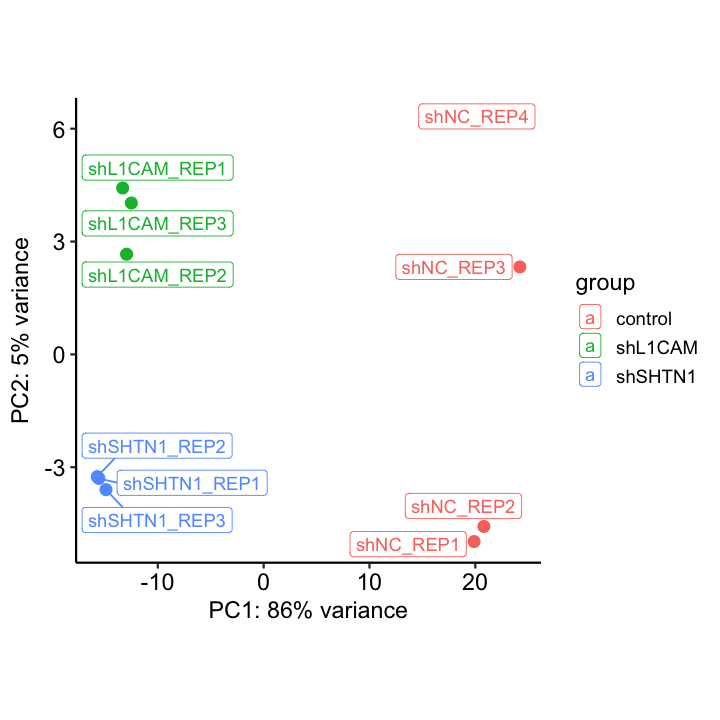

In [10]:
# A bit of QC - looks like PC1 separates controls from treatments, good. PC2 separates shL1CAM from shSHTN1, and also good controls from slight outlier controls.
vsd <- vst(dds, blind=TRUE)

a = plotPCA(vsd, intgroup=c("treatment")) + geom_label_repel(aes(label = name))
w=6;h=6
write_plot(a,outfile='results/deseq2/pca',width=w,height=h)
options(repr.plot.width=6, repr.plot.height=6)
a

## Uncomment to show pairwise plots
#vsd_s1 <- vsd[ , vsd$treatment %in% c("shSHTN1", "control") ]
#b = plotPCA(vsd_s1, intgroup=c("treatment")) + geom_label_repel(aes(label = name))
#vsd_s2 <- vsd[ , vsd$treatment %in% c("shL1CAM", "control") ]
#c = plotPCA(vsd_s2, intgroup=c("treatment")) + geom_label_repel(aes(label = name))
#vsd_s3 <- vsd[ , vsd$treatment %in% c("shL1CAM", "shSHTN1") ]
#d = plotPCA(vsd_s3, intgroup=c("treatment")) + geom_label_repel(aes(label = name))
# options(repr.plot.width=12, repr.plot.height=12)
#(a | b) / (c | d)

In [11]:
## Generate DE comparisons. Wald test with BH correction. Post-hoc LFC shrinkage with apeglm.
res_l1cam <- results(dds, name="treatment_shL1CAM_vs_control",independentFiltering=TRUE)
res_l1cam <- lfcShrink(dds, coef="treatment_shL1CAM_vs_control", res=res_l1cam, type="apeglm")

res_shtn1 <- results(dds, name="treatment_shSHTN1_vs_control",independentFiltering=TRUE)
res_shtn1 <- lfcShrink(dds, coef="treatment_shSHTN1_vs_control", res=res_shtn1, type="apeglm")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [12]:
get_hits <- function(deseq_result,decreasing=FALSE,outfile=NULL){
    res_df <- as.data.frame(deseq_result)  # Convert DESeqResults object to a data frame
    res_df <- res_df[order(res_df$log2FoldChange, decreasing=decreasing),]  # Sort by foldChange
    # Filter by padj < 0.05
    filtered_sorted_res <- res_df[(!is.na(res_df$padj)) & (res_df$padj < 0.05), ]  # Filter by padj
    
    if (!is.null(outfile)) {
        # Write the data frame to a tab-separated file (TSV)
        write.table(res_df, file = outfile, sep = "\t", quote = FALSE)
    }
    return(filtered_sorted_res)
}

In [13]:
# genes down in shL1CAM  
get_hits(res_l1cam,FALSE,outfile='results/deseq2/shL1CAM_deg.tsv') %>% head(n=10)

,baseMean,log2FoldChange,lfcSE,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DHRS3,73.551203,-7.792074,1.8646707,4.821950e-07,2.845058e-06
ENSG00000262633,12.713406,-7.484003,2.6588522,3.477514e-08,2.502343e-07
TMOD1,11.204977,-6.802821,2.6323465,1.099575e-06,6.088156e-06
TPPP3,32.550889,-6.724458,1.6332785,1.029849e-06,5.733112e-06
NR2E1,24.210029,-6.430485,1.4212087,1.798120e-07,1.143047e-06
ENSG00000289517,7.815917,-5.982675,2.7556897,7.295950e-05,2.817783e-04
STMN2,6.525745,-5.972584,2.6819854,4.411303e-05,1.789948e-04
ISLR2,126.464107,-5.738844,0.8065744,4.685916e-14,7.921996e-13
ZNF630,5.646002,-5.713606,2.6621635,7.569552e-05,2.912916e-04


In [14]:
# genes down in shSHTN1  
get_hits(res_shtn1,FALSE,outfile='results/deseq2/shSHTN1_deg.tsv') %>% head(n=10)

,baseMean,log2FoldChange,lfcSE,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DHRS3,73.551203,-10.216497,3.2925852,2.100463e-08,1.411448e-07
H4C11,21.921668,-8.141271,2.7676335,7.418258e-09,5.364126e-08
ENSG00000262633,12.713406,-7.502572,2.6633737,3.305370e-08,2.163205e-07
XKR4,8.145134,-6.600995,2.6086324,1.953358e-06,9.540905e-06
NR2E1,24.210029,-6.447639,1.4213992,1.717460e-07,1.005757e-06
FAM72D,7.841262,-5.899647,2.5455090,1.581017e-05,6.482412e-05
PPP2R2B,58.935373,-5.872950,0.6694164,1.886284e-18,4.210908e-17
SLC6A11,15.748080,-5.768965,1.3001486,3.707902e-07,2.059859e-06
ZNF630,5.646002,-5.736745,2.6650697,7.330021e-05,2.641548e-04


In [15]:
# Lookup genes of interest
genes_of_interest = c('SHTN1','L1CAM','CCN2','CCN1') # CTGF = CCN2; CYR61 =  CCN1
res_shtn1[rownames(res_shtn1) %in% genes_of_interest,]
message("")
res_l1cam[rownames(res_l1cam) %in% genes_of_interest,]

log2 fold change (MAP): treatment shSHTN1 vs control 
Wald test p-value: treatment shSHTN1 vs control 
DataFrame with 4 rows and 5 columns
       baseMean log2FoldChange     lfcSE      pvalue        padj
      <numeric>      <numeric> <numeric>   <numeric>   <numeric>
CCN2    66.3053       0.424880  0.284654 7.93286e-02 1.32181e-01
CCN1    78.8271       0.659786  0.342820 1.86011e-02 3.78305e-02
SHTN1  427.8800      -2.795970  0.150299 1.36573e-78 6.73000e-76
L1CAM 8963.9789       0.395422  0.110134 2.31961e-04 7.57173e-04

log2 fold change (MAP): treatment shL1CAM vs control 
Wald test p-value: treatment shL1CAM vs control 
DataFrame with 4 rows and 5 columns
       baseMean log2FoldChange     lfcSE      pvalue        padj
      <numeric>      <numeric> <numeric>   <numeric>   <numeric>
CCN2    66.3053       0.584667  0.294205 1.74382e-02 3.69452e-02
CCN1    78.8271       0.627809  0.343259 2.18279e-02 4.48318e-02
SHTN1  427.8800      -0.816738  0.125488 1.97612e-11 2.37080e-10
L1CAM 8963.9789      -0.266483  0.109744 1.24584e-02 2.75486e-02

In [16]:
# Log normalized expression scaled by library size.
# https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#extracting-transformed-values
assay(vsd)[rownames(vsd) %in% genes_of_interest, ]

,shL1CAM_REP1,shL1CAM_REP2,shL1CAM_REP3,shNC_REP1,shNC_REP2,shNC_REP3,shNC_REP4,shSHTN1_REP1,shSHTN1_REP2,shSHTN1_REP3
CCN2,7.220659,7.071480,7.127361,6.372886,6.628518,6.713322,7.116397,6.876036,7.102694,7.097815
CCN1,7.220659,7.259189,7.328083,6.446551,6.396760,6.779011,7.334858,7.187742,7.384585,7.267135
SHTN1,8.877574,8.689018,8.927164,9.473827,9.490791,9.680348,9.670239,7.377122,7.102694,7.463500
L1CAM,12.843804,12.772040,12.784017,13.288781,13.221947,12.957602,12.780416,13.468598,13.498215,13.483382
